In [42]:
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

RANDOM_STATE = 42
TARGET_COL = "Class"
TEST_SIZE = 0.2

In [43]:
PROJECT_ROOT = Path("..").resolve()
DATA_RAW = PROJECT_ROOT / "data" / "raw"
SPLITS_DIR = PROJECT_ROOT / "data" / "splits"
REPORTS_DIR = PROJECT_ROOT / "reports"

# Ensure the directory exists
DATA_RAW.mkdir(parents=True, exist_ok=True)
SPLITS_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# Check if the file exists before reading
csv_file = DATA_RAW / "creditcard.csv"
if csv_file.exists():
    df = pd.read_csv(csv_file, low_memory=False)  # Suppress DtypeWarning
    df.head(10)
else:
    print(f"File not found: {csv_file}")


In [44]:
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

In [45]:
train_idx = pd.read_csv(SPLITS_DIR / "X_train.csv", header=None).squeeze()

X_train = X.loc[train_idx].copy()
y_train = y.loc[train_idx].copy()

In [46]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

v_columns = [f"V{i}" for i in range(1, 29)]
amount_col = ["Amount"]
time_col = ["Time"]

SECONDS_IN_DAY = 86400

def time_cyc_features(X):
    t = (X % SECONDS_IN_DAY) / SECONDS_IN_DAY
    return np.hstack([np.sin(2 * np.pi * t), np.cos(2 * np.pi * t)])

def coerce_numeric_df(X):
    X = X.copy()
    for c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="coerce")
    return X

to_numeric = FunctionTransformer(coerce_numeric_df, validate=False)

amount_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("log1p", FunctionTransformer(np.log1p, validate=True)),
    ("scaler", StandardScaler()),
])

v_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

time_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("cyc", FunctionTransformer(time_cyc_features, validate=True)),
    ("scaler", StandardScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("amount", amount_transformer, amount_col),
        ("time", time_transformer, time_col),
        ("v", v_transformer, v_columns),
    ],
    remainder="drop"
)

model = Pipeline(steps=[
    ("to_numeric", to_numeric),
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="liblinear"
    ))
])

model.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('to_numeric', ...), ('preprocessor', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function coe...t 0x118892020>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword argument

In [47]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

y_pred = cross_val_predict(model, X_train, y_train, cv=skf)

oof_proba = cross_val_predict(model, X_train, y_train, cv=skf, method="predict_proba")[:, 1]

In [48]:
precision, recall, thresholds = precision_recall_curve(y_train, oof_proba)
thr_ext = np.r_[0.0, thresholds]
print(len(precision), len(recall), len(thr_ext))


227471 227471 227471


In [49]:
import sys
from pathlib import Path

# Add the parent directory of 'src' to sys.path
sys.path.append(str(PROJECT_ROOT))

from src.choose_thresholds import choose_threshold_max_recall_at_fpr

chosen_thr, strategy, metrics,fpr = choose_threshold_max_recall_at_fpr(
    y_true=y_train,
    proba=oof_proba,
    max_fpr=0.001
)

print(f"Chosen threshold: {chosen_thr} using strategy: {strategy}")
print("Metrics at chosen threshold:")
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

Chosen threshold: 0.9898731402482259 using strategy: Max recall with FPR≤0.0010
Metrics at chosen threshold:
threshold: 0.9899
fpr: 0.0010
recall: 0.8325
precision: 0.5942
f1: 0.6934


In [50]:
oof_pred_chosen = (oof_proba >= chosen_thr).astype(int)
cm = confusion_matrix(y_train, oof_pred_chosen)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[227227    224]
 [    66    328]]


In [51]:
from sklearn.metrics import brier_score_loss

brier_score = brier_score_loss(y_train, oof_pred_chosen)
print(f"Brier Score: {brier_score:.4f}")

Brier Score: 0.0013


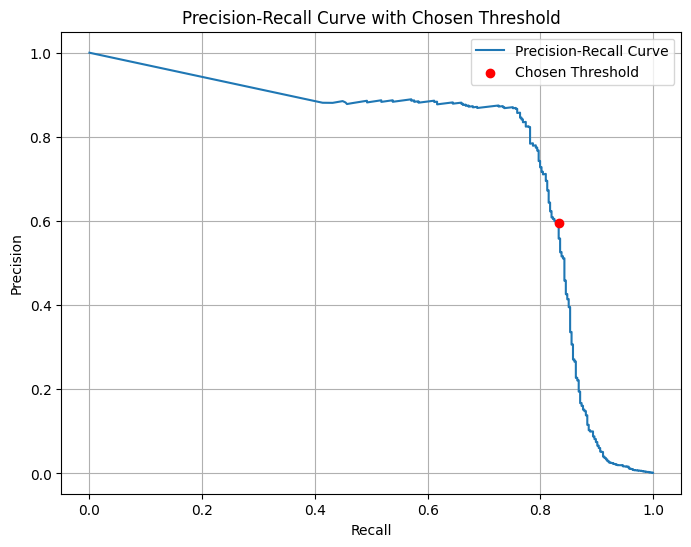

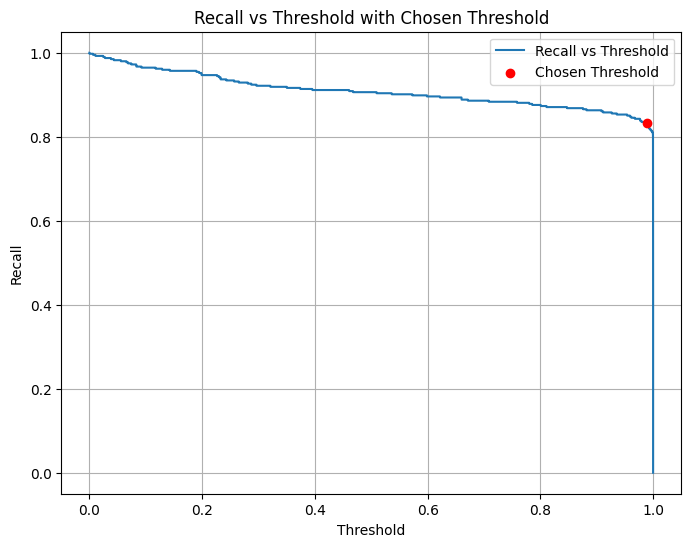

In [54]:
#PR curve for chosen threshold

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.scatter(metrics['recall'], metrics['precision'], color='red', label='Chosen Threshold', zorder=5)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with Chosen Threshold")
plt.legend()
plt.grid()
plt.savefig(REPORTS_DIR / "pr_curve_chosen_threshold.png")
plt.show()

#Recall@FixedPRecision graph

plt.figure(figsize=(8, 6))
plt.plot(thr_ext, recall, label="Recall vs Threshold")
plt.scatter(chosen_thr, metrics['recall'], color='red', label='Chosen Threshold', zorder=5)
plt.xlabel("Threshold")
plt.ylabel("Recall")
plt.title("Recall vs Threshold with Chosen Threshold")
plt.legend()
plt.grid()
plt.savefig(REPORTS_DIR / "recall_vs_threshold_chosen_threshold.png")

